In [1]:
import sys
sys.path.append('..')
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
from metpy.units import units

from Map import Map
from Data import Data, ValidTime

In [14]:
'''Define Model Parameters'''
LOCATION = 'texas'
PRODUCT = '3 hour'
MODEL_DATE = '20230610'
CYCLE = '18'
FORECAST_HOUR = '12'

# Define area to retrieve data
LEFT_LON = -100
RIGHT_LON = -80
TOP_LAT = 40
BOTTOM_LAT = 24

In [15]:
PRODUCT_MAPPING = {'1 hour': 1, '3 hour': 2}.get(PRODUCT, '1 hour')

graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [16]:
URL = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
       f'file=href.t{CYCLE}z.conus.pmmn.f{FORECAST_HOUR}.grib2'
       f'&all_lev=on&var_APCP=on'
       f'&subregion=&leftlon={360 + LEFT_LON}&rightlon={360 + RIGHT_LON}'
       f'&toplat={TOP_LAT}&bottomlat={BOTTOM_LAT}&'
       f'dir=/href.{MODEL_DATE}/ensprod')

ds = Data(URL)
data = ds.pygrib_read_dataset()

In [17]:
#%%capture
pmm_product = data[PRODUCT_MAPPING]

# Extract lats, lons, and data values
lats, lons = pmm_product.latlons()
href_values = pmm_product.values

# Attach units
href_values = units('mm') * href_values
href_values = href_values.to('in')

# Get Valid Local Time
vt = ValidTime(pmm_product.validityDate, pmm_product.validityTime, 'America/Chicago')
VALID_TIME = vt.convert_datetime_pygrib()

In [18]:
txt = (str(pmm_product))
product = txt.split(':')[6].split(' ')[2].split('-')
accumulated_hours = int(product[1]) - int(product[0])
title = f'{accumulated_hours} hours' if accumulated_hours > 1 else f'{accumulated_hours} hour'

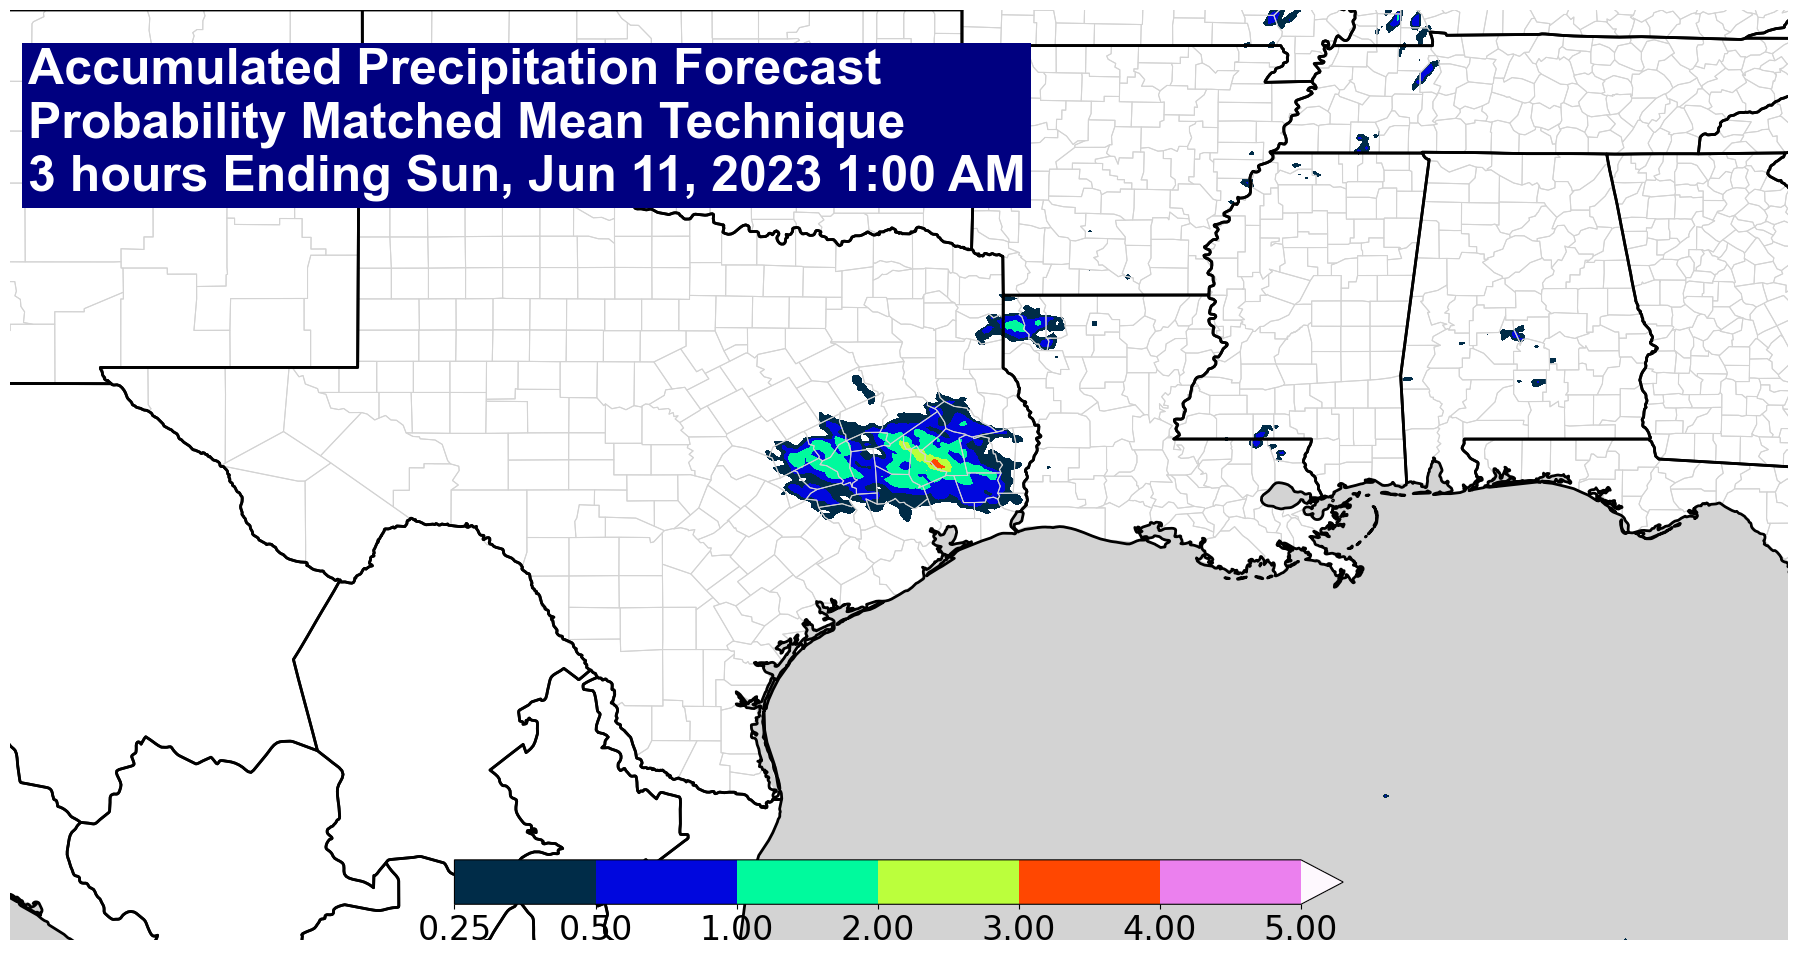

In [25]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'Accumulated Precipitation Forecast\nProbability Matched Mean Technique\n'
                  f'{title} Ending {VALID_TIME}')

fig, ax = new_map.make_map()

data_range = [0.25, 0.50, 1.00, 2.00, 3.00, 4.00, 5.00]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.gist_ncar, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Save and show figure
plt.savefig(f"{graphics_dir}/precip-pmmn-{str(accumulated_hours)}-hr_{FORECAST_HOUR}.png", dpi=72)
plt.show()